<a href="https://colab.research.google.com/github/GalynaDe/ML/blob/main/HW_2_5_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('drive/MyDrive/ML course 2024/HW 2.5/train.csv.zip')
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
data.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



# Середнє значення продажів з довірчим інтервалом для кожного айтему:

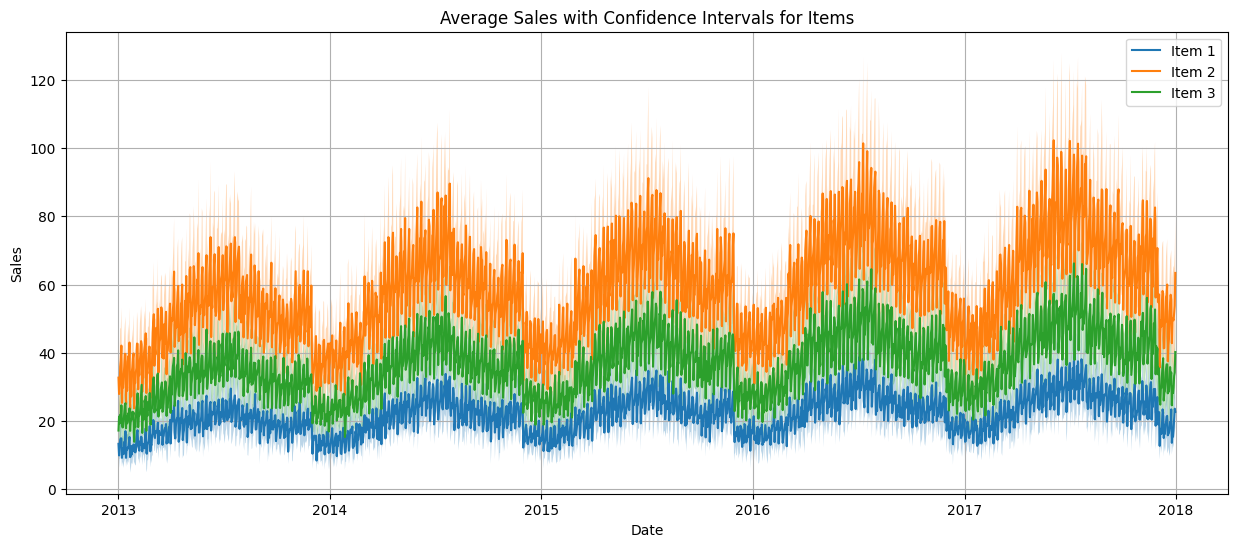

In [12]:
data = pd.read_csv('drive/MyDrive/ML course 2024/HW 2.5/train.csv.zip')
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)

# Групуємо дані для обчислення середнього та стандартного відхилення
mean_sales = data.groupby(['date', 'item'])['sales'].mean().reset_index()
std_sales = data.groupby(['date', 'item'])['sales'].std().reset_index()

# Об'єднуємо середні значення і стандартні відхилення
summary = mean_sales.merge(std_sales, on=['date', 'item'], suffixes=('_mean', '_std'))
summary['lower_bound'] = summary['sales_mean'] - summary['sales_std']
summary['upper_bound'] = summary['sales_mean'] + summary['sales_std']

plt.figure(figsize=(15, 6))
for item in summary['item'].unique()[:3]:  # Візуалізуємо перші 3 айтеми
    item_data = summary[summary['item'] == item]
    plt.plot(item_data['date'], item_data['sales_mean'], label=f'Item {item}')
    plt.fill_between(item_data['date'], item_data['lower_bound'], item_data['upper_bound'], alpha=0.3)

plt.title('Average Sales with Confidence Intervals for Items')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Порівняння динаміки продажів між кількома айтемами в одному магазині:

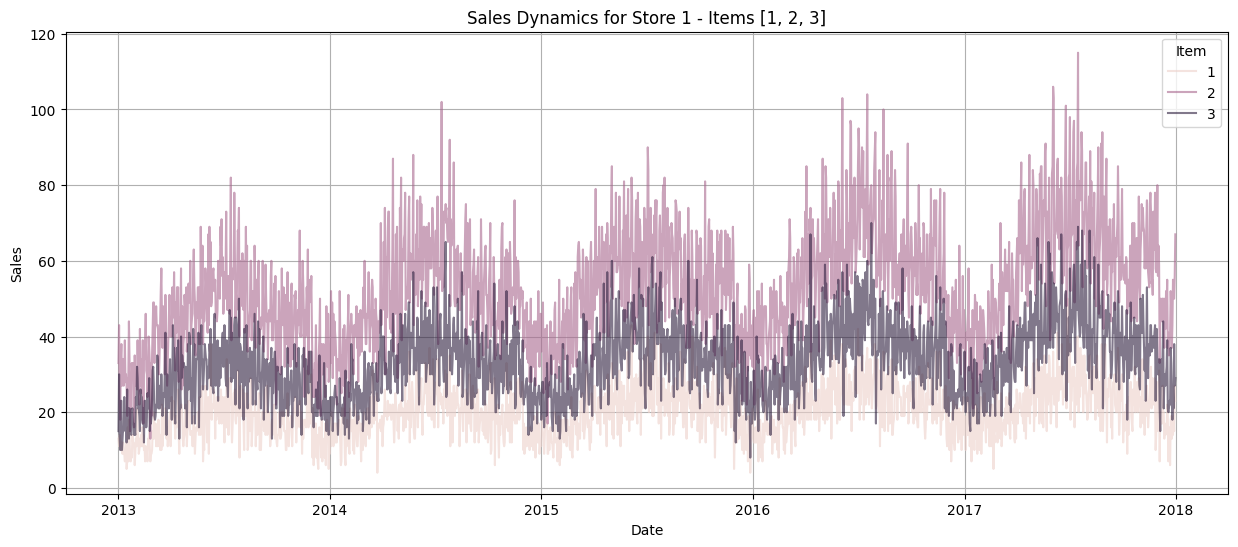

In [16]:
# Вибираємо один магазин та три айтеми
store_id = 1
items_to_plot = [1, 2, 3]

# Фільтруємо дані за магазином та айтемами
store_data = data[(data['store'] == store_id) & (data['item'].isin(items_to_plot))]

plt.figure(figsize=(15, 6))
sns.lineplot(data=store_data, x='date', y='sales', hue='item', alpha=0.6)
plt.title(f'Sales Dynamics for Store {store_id} - Items {items_to_plot}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Item')
plt.grid(True)
plt.show()

# Сумарні продажі по магазинам для обраного айтема:

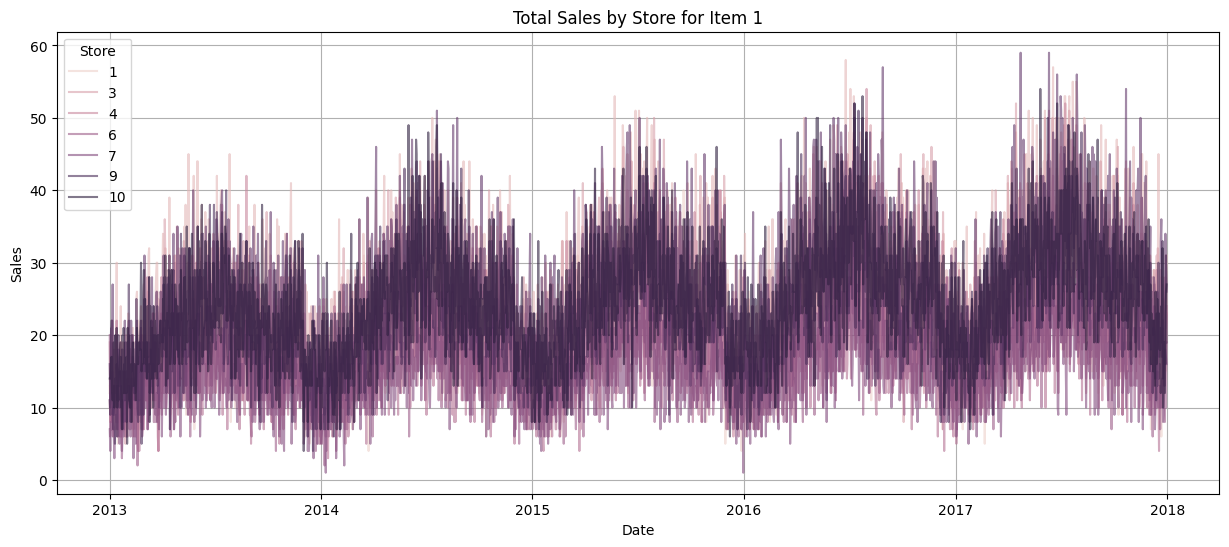

In [15]:
item_id = 1
item_store_sales = data[data['item'] == item_id].groupby(['date', 'store'])['sales'].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=item_store_sales, x='date', y='sales', hue='store', alpha=0.6)
plt.title(f'Total Sales by Store for Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.grid(True)
plt.show()

**Висновок:**
Динаміка в магазинах по продажам айтемів схожа, при цьому обʼєми продажів різні також об*єм продажів для 1 айтему можна побачити на 3 графіку в різних магазинах.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [17]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00


In [18]:
from darts import TimeSeries
data_i1_s1 = data[(data.item == 1) & (data.store == 1)]
data_i1_s1.shape

(1826, 3)

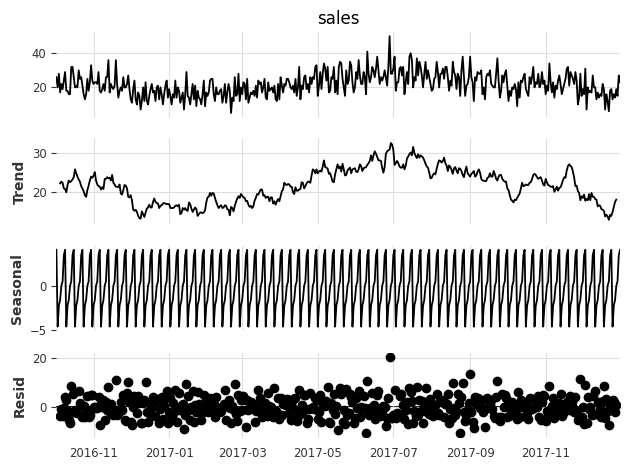

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиція для часового ряду
decomposition_plot_multi = seasonal_decompose(data_i1_s1['sales'][-456:],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

Бачимо річний цикл.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [23]:
series = TimeSeries.from_dataframe(data_i1_s1, value_cols=['sales'])

<Axes: xlabel='date'>

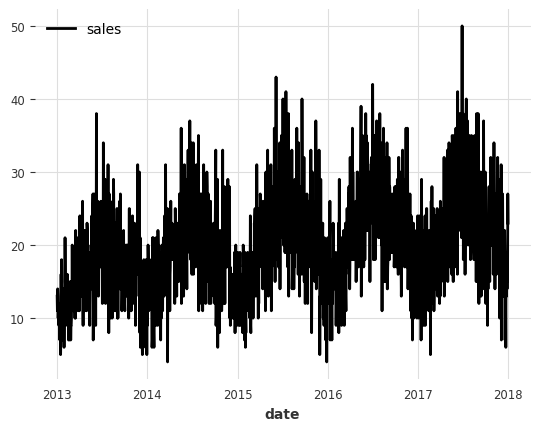

In [24]:
series['sales'].plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

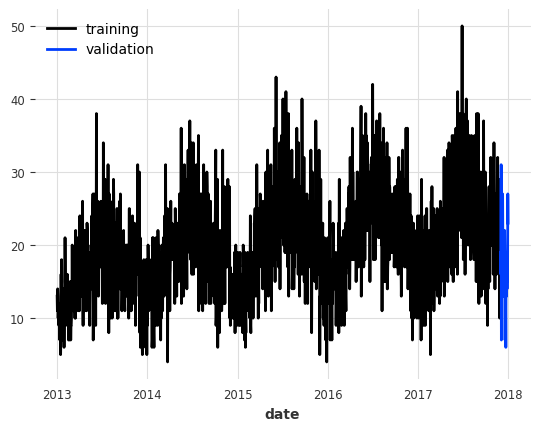

In [25]:
train, val = series.split_before(pd.Timestamp("2017-12-01"))
n_predict = len(val)
train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

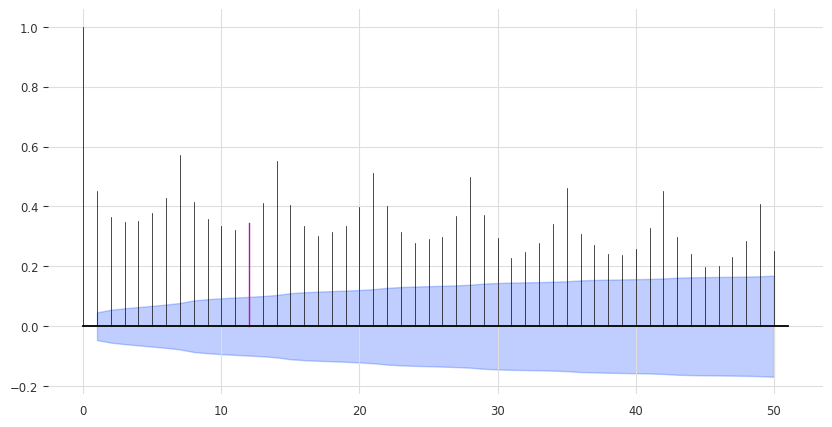

In [26]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=50)

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [27]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

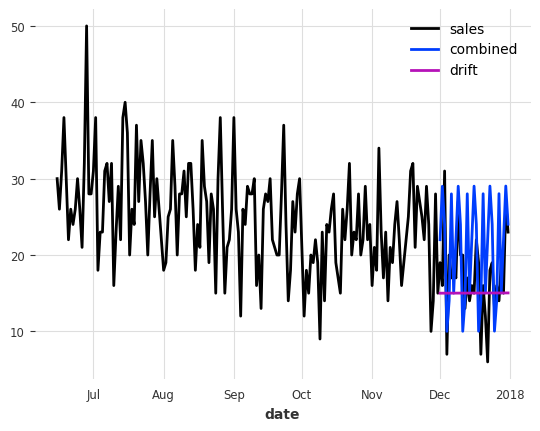

In [28]:
from darts.models import NaiveSeasonal, NaiveDrift

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(n_predict)

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(n_predict)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series[-200:].plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

Модель не може бути достатньо точною для практичного використання в бізнесі, треба викристати більш складні моделі ARIMA, SARIMA

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [29]:
from darts.metrics import mape

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

In [30]:
eval_forecast('naive', val, combined_forecast)

model naive obtains MAPE: 45.77%


45.7661327927124

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [31]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["day"] = df['date'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=7,
    output_chunk_length=1,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

array([[0.30303344],
       [0.44011638],
       [0.37967706],
       [0.34828874],
       [0.32126117],
       [0.40915456]], dtype=float32)

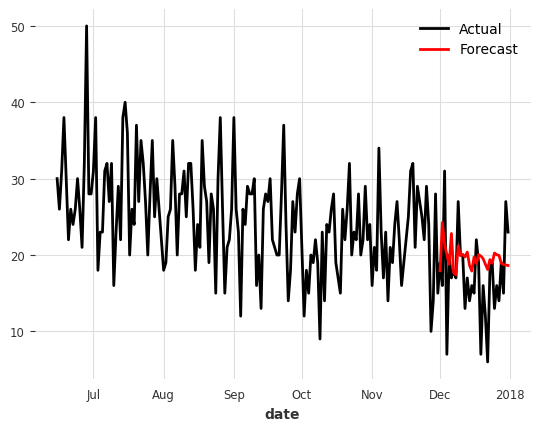

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 38.06%


38.062464711005425

In [32]:
forecast = scaler.inverse_transform(model.predict(n_predict))
series[-200:].plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast)

МАРЕ показує кращий резуотат ніж попередня модель. Але бачимо, що не достатньоо добре вгадує варіативність в даних.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

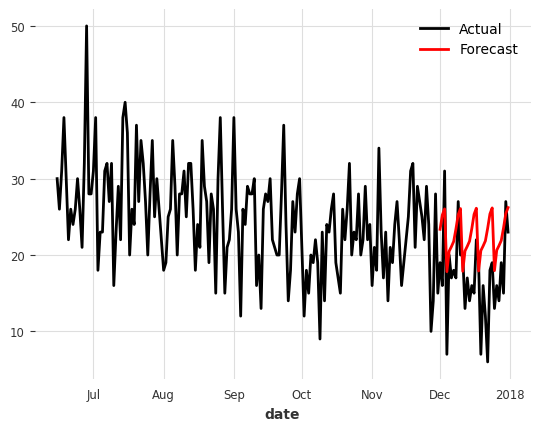

model ExponentialSmoothing() obtains MAPE: 50.04%


In [33]:
from darts.models import ExponentialSmoothing

def plot_results(series, forecast):
  # Візуалізація результатів
  series[-200:].plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

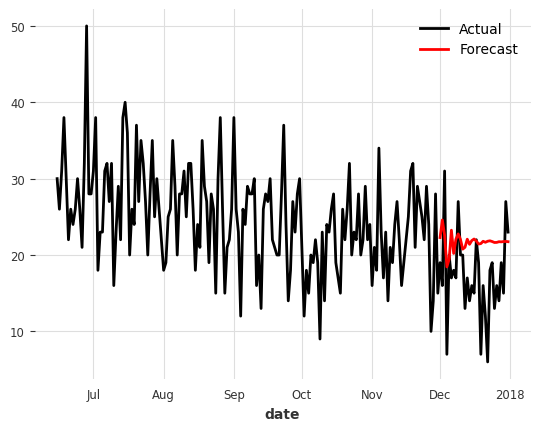

model ARIMA(p=7, q=1) obtains MAPE: 47.72%


In [35]:
from darts.models import ARIMA

model = ARIMA(p=7, d=1, q=1)
fit_and_plot(model, series, train, val)

поганий результат

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, start_p=7, max_p=21, start_q=1)

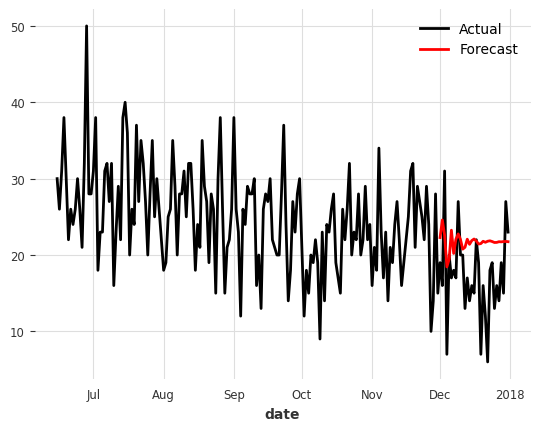

In [36]:
from darts.models import AutoARIMA

model = AutoARIMA(start_p=7, max_p=21, start_q=1) # спробуйте стартувати з інших значень і перегляньте, що виходить
model.fit(train)

display(model)
forecast = model.predict(len(val))
plot_results(series, forecast)

In [37]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1795
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5474.395
Date:                Sun, 16 Mar 2025   AIC                          10966.789
Time:                        12:11:22   BIC                          11016.219
Sample:                             0   HQIC                         10985.039
                               - 1795                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0458      0.037      1.251      0.211      -0.026       0.118
ar.L2         -0.0679      0.032     -2.089      0.037      -0.132      -0.004
ar.L3         -0.0666      0.032     -2.078      0.038      -0.130      -0.004
ar.L4         -0.0575      0.032     -1.775      0.076      -0.121       0.006
ar.L5         -0.0280      0.031     -0.894      0.371      -0.089       0.033
ar.L6          0.0122      0.029      0.416      0.677      -0.045       0.070
ar.L7          0.2743      0.028      9.689      0.000       0.219       0.330
ma.L1         -0.9141      0.025    -36.625      0.000      -0.963      -0.865
sigma2        26.1486      0.812     32.215      0.000      24.558      27.739
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.20
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [38]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast = model.predict(len(val))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpil8hib53/9e_he3ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpil8hib53/d0xmjqon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48654', 'data', 'file=/tmp/tmpil8hib53/9e_he3ba.json', 'init=/tmp/tmpil8hib53/d0xmjqon.json', 'output', 'file=/tmp/tmpil8hib53/prophet_modelg5grq6l7/prophet_model-20250316121155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


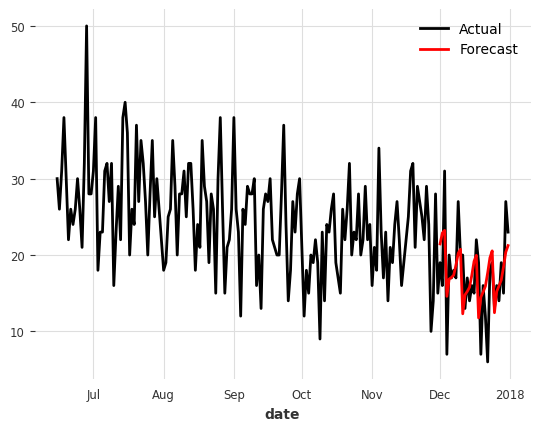

model Prophet() obtains MAPE: 27.51%


27.507166837005773

In [40]:
series[-200:].plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast)

Набагато кращий результат порівнюючи з попередніми

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [41]:
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Масштабування даних
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# Створити серії з атрибутом року і місяця
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=len(series)),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_before(pd.Timestamp("2017-12-01"))

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)
7         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, input_chunk_length=14, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

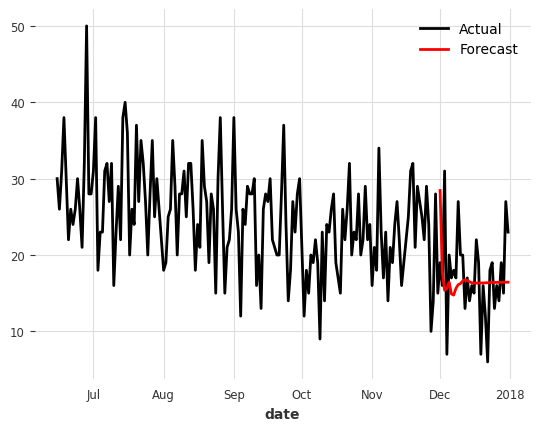

model RNNModel(model=LSTM, hidden_dim=20, training_length=20, input_chunk_length=14, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True) obtains MAPE: 31.29%


31.293127505780912

In [42]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series[-200:].plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model, val, forecast)

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/367 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpil8hib53/dxy6iqeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpil8hib53/yjqtlcrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64294', 'data', 'file=/tmp/tmpil8hib53/dxy6iqeu.json', 'init=/tmp/tmpil8hib53/yjqtlcrc.json', 'output', 'file=/tmp/tmpil8hib53/prophet_modelxp993l4c/prophet_model-20250316122908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:29:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:29:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/367 [00:00<03:43,  1.63it/s]INFO:prophet

MAPE = 21.18%


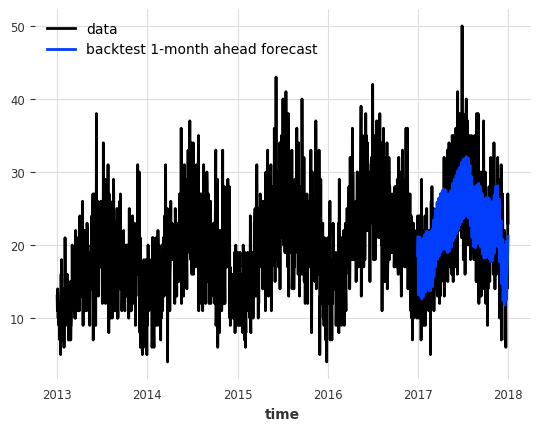

In [43]:
model = Prophet()
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2016-12-01"),
    "forecast_horizon": 30,
    "verbose": True,
    "enable_optimization": True
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast.plot(label="backtest 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

Результат доволі не поганий, але повністю вариативність не передбачає

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б застосувала Facebook Prophet для швидкого отримання прогнозів. Для цього я б навчала окрему модель для кожного товару в кожному магазині. На етапі дослідження я б спробувала використати стандартний XGBoost, створивши одну модель для всіх товарів і магазинів. Кожну вибрану модель я б обов’язково перевірила на бектесті перед тим, як передати її у використання.